<a href="https://colab.research.google.com/github/allanbispo/Redes-Neurais-CESAR-School/blob/2023.02/apsb_4_2_Iris_dataset_2_ou_mais_camadas_fronteira_dinamica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **ATIVIDADE AULA 4.2**

## **CESAR SCHOOL**
* Pós-graduação em Engenharia e Análise de Dados - 2023.2
* **Disciplina: RNA e Deep Learning**
* Professor: **Vitor Casadei**
* Aluno: **Allan Bispo** - apsb@cesar.school

# Rede neural com camadas escondidas - Classificação do Iris dataset

O objetivo desse experimento é ilustrar o uso de rede neural que tenha mais de uma camada. Isso é conseguido com a inserção de uma ativação não linear entre as camadas.

Datasets utilizados:
    - Iris - 3 classes
    - Sintéticos:
        - meia luas
        - círculos circunscritos
        - blobs

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/Net2RegressaoSoftmaxArgmaxRede.png)

## Importando as bibliotecas

In [208]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

## Leitura, normalização e visualização dos dados

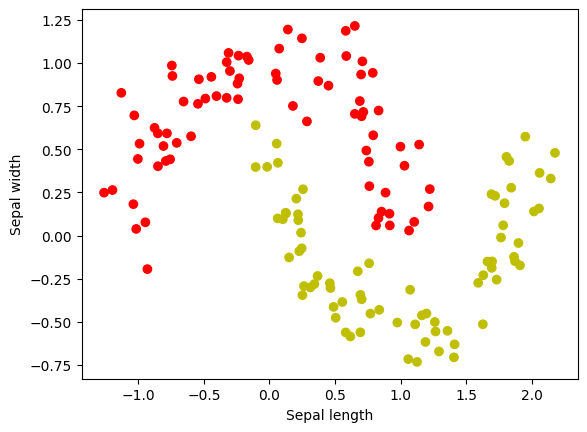

In [209]:
n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option == 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option == 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option == 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option == 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [210]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

## Construindo o modelo da rede

In [211]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 7),
            nn.ReLU(),
            nn.Linear(7, 7),
            nn.ReLU(),
            nn.Linear(7, 7),
            nn.ReLU(),
            nn.Linear(7,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=7, bias=True)
    (1): ReLU()
    (2): Linear(in_features=7, out_features=7, bias=True)
    (3): ReLU()
    (4): Linear(in_features=7, out_features=7, bias=True)
    (5): ReLU()
    (6): Linear(in_features=7, out_features=3, bias=True)
  )
)


## _predict_ utilizada para predição de classes e na visualização

In [212]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

## Classe para visualização dinâmica

In [213]:
class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
              # Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

## Treinamento

In [214]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

### Laço principal de treinamento

Final loss: tensor(0.0019)


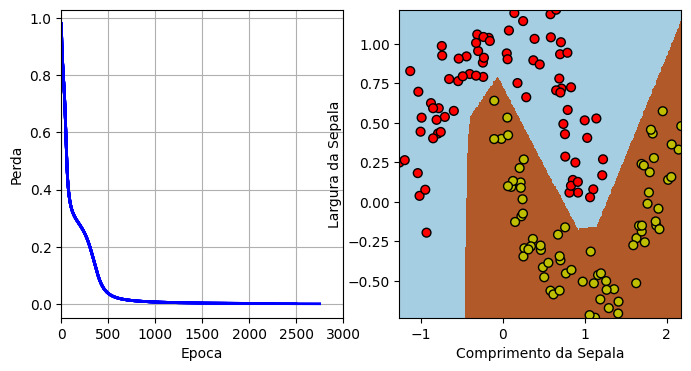

In [215]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

## Avaliação

### Imprimindo pesos finais

In [216]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

dense.0.weight  torch.Size([7, 2])
tensor([[ 0.7461,  0.9429],
        [-0.1961,  0.4714],
        [ 1.1637,  0.5803],
        [-2.0454,  0.0748],
        [ 1.1401,  0.9636],
        [ 0.3734,  0.3743],
        [ 1.3949, -0.2591]])
dense.0.bias    torch.Size([7])
tensor([-0.1432, -0.4970, -1.2462, -0.1867, -0.0936,  0.0442, -1.3176])
dense.2.weight  torch.Size([7, 7])
tensor([[-0.1927, -0.3409, -0.0725, -0.0588, -0.2538,  0.0589,  0.3296],
        [ 0.5667, -0.0738, -1.0454,  0.5312,  0.6642,  0.2819, -0.5589],
        [-0.1355, -0.0764, -0.3211, -0.0825,  0.1577, -0.0886, -0.0362],
        [-0.0468, -0.2625,  0.1895, -0.4830,  0.0846,  0.2366,  0.2386],
        [ 0.4431,  0.2294, -0.7205,  1.1265,  0.3777,  0.4255, -1.0012],
        [ 0.7253, -0.2517, -1.0492,  1.4070,  0.8302,  0.2675, -1.2663],
        [ 0.2838,  0.1433,  0.1291, -0.2449,  0.2881,  0.3526, -0.0404]])
dense.2.bias    torch.Size([7])
tensor([-0.2600, -0.3307, -0.1053,  0.4802, -0.1105, -0.6288, -0.0588])
dense.4.weigh

### Avaliação do classificador

In [217]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  1.0


### Matriz de confusão

In [218]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,75,0
1,0,75


## Atividades

### Experimentos:

1. Faça alterações na rede, alterando o número de neurônios, de camadas. Escreva suas conclusões.
  * `apsb`: como referência tem-se a rede com 5 neurônios e activation via 1 camada de ReLu:
    * Perda Final: 0.2564
    * Acurácia: 0.88
  * `apsb`: testando com 3, 7 e 10 neurônios a rede, sem alterar camada:
    * `3 neurônios`: apresentou o binômio perda/acurácia de 0.2454/0.87, um desempenho ligeiramente abaixo da referência, não caracterizando necessariamente undershooting.
    * `7 neurônios`: perda/acurácia de 0.0028/1.00, nessa configuração houve um desempenho excelente, todavia inseja um possível overshooting.
    * `10 neurônios`: perda/acurácia de 0.0347/0.90, com 10 neurônios já há um retorno de perdas, indicando um desperdício de recursos computacionais, sendo mais eficiente retornar para de 5 a 7 neurônios.
  * `apsb`: testando com 2 e 3 camadas, mantendo 5 neurônios:
    * `2 camadas ReLU`: com somente mais 1 camada de ativação ReLU já se obteve o binômio perda/acurácia de 0.0063/1.00, com os mesmos 5 neurônios de referência.
    * `3 camadas ReLU`: com 3 camadas de ativação ReLU, tanto a perda quanto a acurácia foram 'perfeita' 0.0001/1.00.
  * `apsb`:
    * Conclusões: para essa rede o número mínimo de neurônios seria 5, com 2 camadas ReLU ao menos. Com menos neurônios, 4 por exemplo, até mesmo com 3 camadas a performance não é boa. Não adianta mais de 7 neurônios pois o binômio erro/acurâcia não melhora. Assim, havendo disponibilidade de processamento, deve-se usar mais de 1 camada de ativação.

2. No lugar da ReLU, coloque Sigmoid e observe a diferença. O que aconteceu? Descreva.
  * `apsb`: com uma camada de ativação somente, tanto com 5 ou 7 neurônios, a performance usando Sigmoid foi pior que com ReLU, conforme resultados dos binônios n_5 = 0.3001/0.87 e n_7 = 0.3144/0.85.
  * `apsb`: mesmo adicionando mais uma camada de Sigmoid, e ambas camadas com 7 neurônios, a performance não melhora, mantendo-se em 0.31/0.85.
  * `apsb`: para  esse tipo de dataset a função de ativação ReLU é a mais apropriada pois consegue um melhor treinamento do modelo.
3. O que ocorre quando não se utiliza ativação não linear entre camadas?
  * `apsb`: Conforme esperado o não emprego das funções de ativação impacta no desempenho pois, o modelo não consegue treinar dados não lineares. Mesmo aumentando o número de neurônios e/ou de camadas o erro é pior que quando se usa ReLU.

## Principais aprendizados